In [2]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('data_tmp/bakery_sales.csv')
data.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


In [3]:
baguette = data[data['article'].str.contains("BAGUETTE", case=False, na=False)]

In [4]:
baguette.drop(columns=["Unnamed: 0"])

,date,time,ticket_number,article,Quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"
5,2021-01-02,09:25,150043.0,BAGUETTE,2.0,"0,90 €"
8,2021-01-02,09:32,150045.0,TRADITIONAL BAGUETTE,3.0,"1,20 €"
12,2021-01-02,09:37,150046.0,TRADITIONAL BAGUETTE,6.0,"1,20 €"
...,...,...,...,...,...,...
233996,2022-09-30,18:34,288908.0,CEREAL BAGUETTE,2.0,"1,35 €"
233997,2022-09-30,18:39,288910.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"
233999,2022-09-30,18:52,288911.0,TRADITIONAL BAGUETTE,5.0,"1,30 €"
234003,2022-09-30,18:55,288912.0,TRADITIONAL BAGUETTE,1.0,"1,30 €"


In [5]:
baguette.loc[:, 'datetime'] = pd.to_datetime(baguette['date'] + ' ' + baguette['time'])

C:\Users\maxca\AppData\Local\Temp\ipykernel_11652\1485578767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baguette.loc[:, 'datetime'] = pd.to_datetime(baguette['date'] + ' ' + baguette['time'])


In [6]:
df_hourly = baguette.set_index('datetime').resample('h')['Quantity'].sum()

In [7]:
df_daily = baguette.set_index('datetime').resample('D')['Quantity'].sum()

In [8]:
df_monthly = baguette.set_index('datetime').resample('ME')['Quantity'].sum()

In [9]:
df_yearly = baguette.set_index('datetime').resample('YE')['Quantity'].sum()

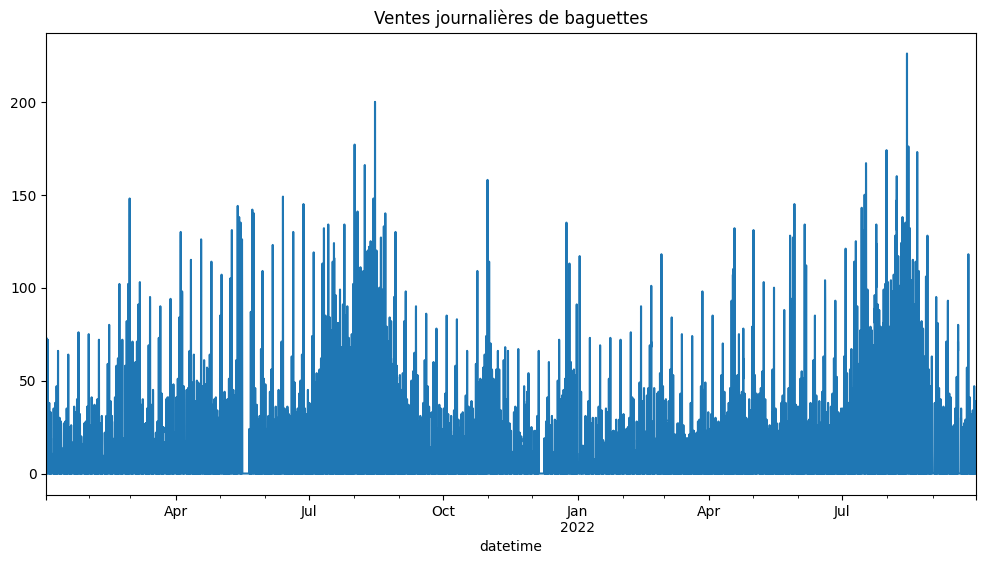

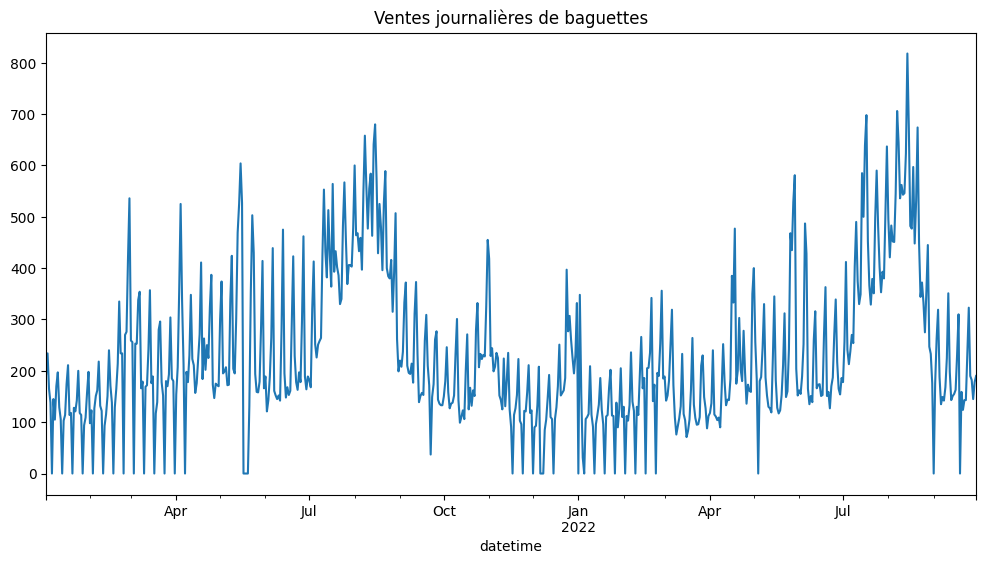

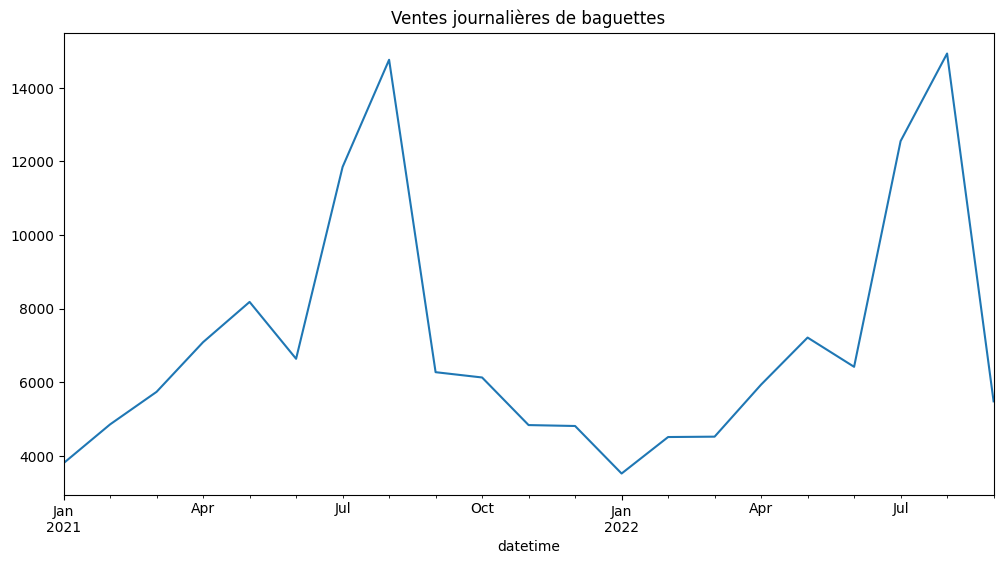

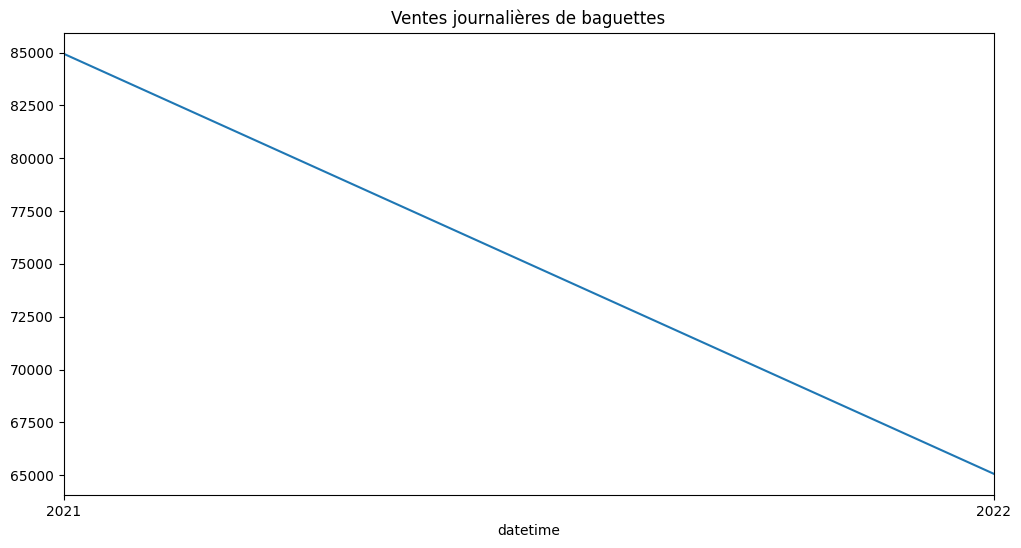

In [70]:
import matplotlib.pyplot as plt

for data_frame in [df_hourly, df_daily, df_monthly, df_yearly]:
    data_frame.plot(figsize=(12,6), title="Ventes journalières de baguettes")
    plt.show()


# Pévisons avec SARIMAX

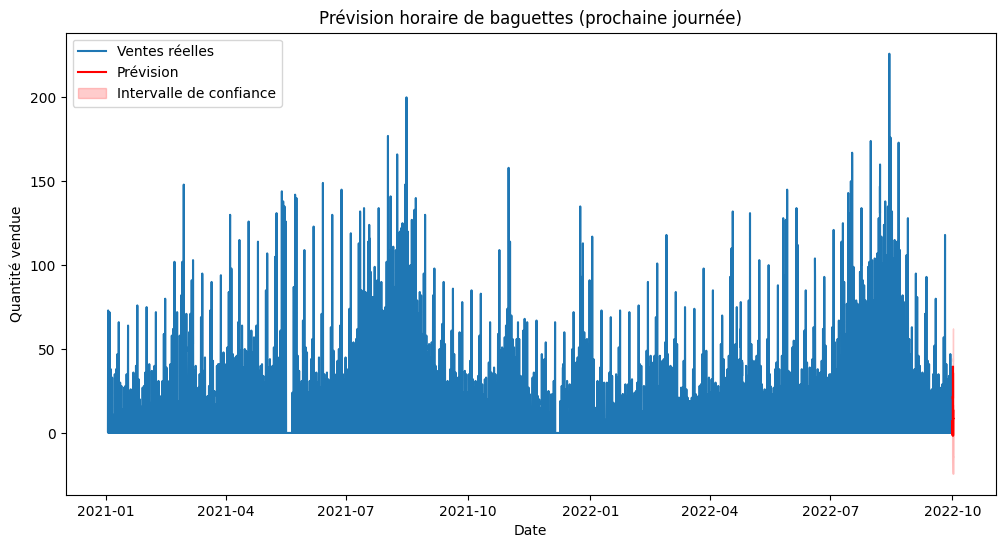

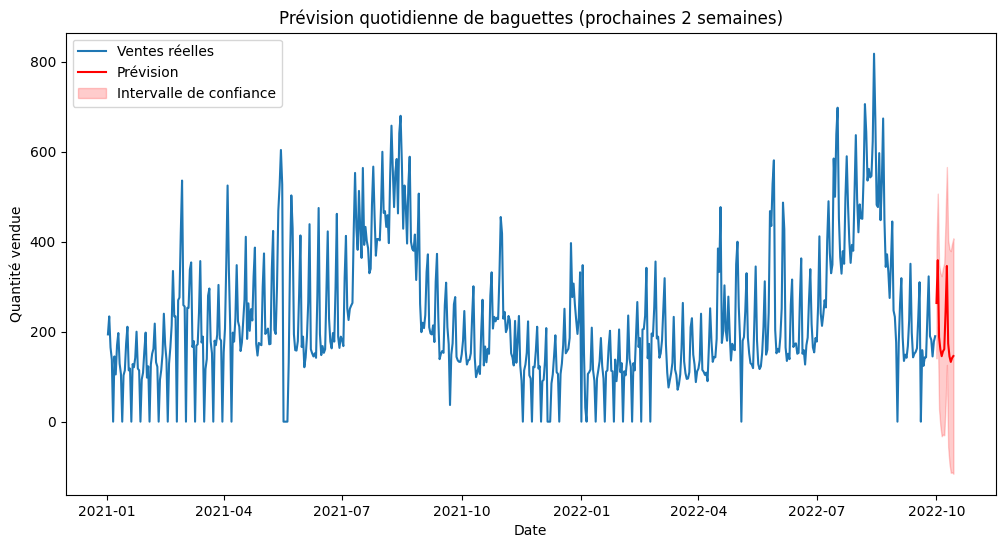

c:\Users\maxca\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\maxca\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


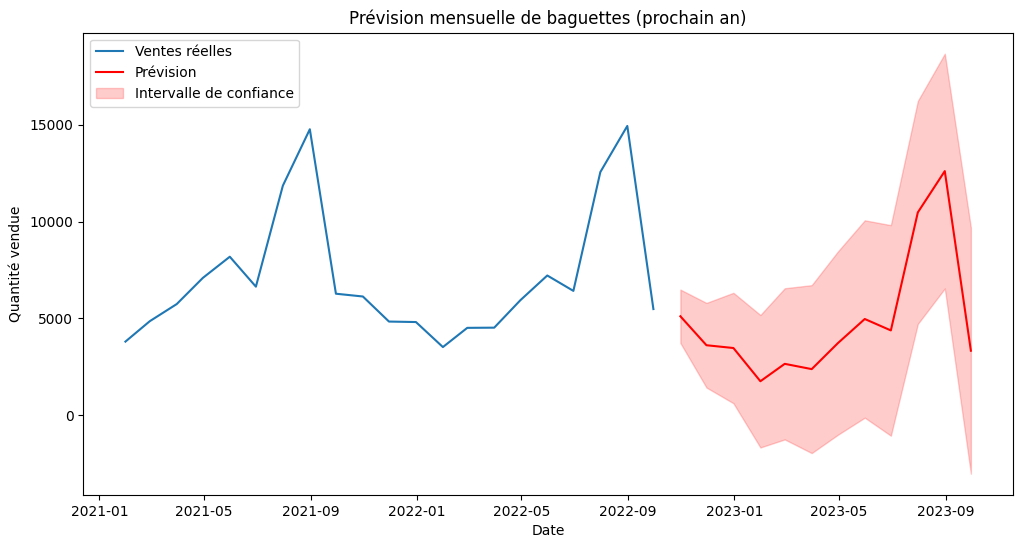

In [76]:
# Fonction pour faire prévision et graphique
def forecast_plot(df, resample_rule, steps, title, seasonal_period):
    ts = df.set_index('datetime').resample(resample_rule)['Quantity'].sum()
    
    # Ajustement SARIMA
    model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,seasonal_period))
    results = model.fit(disp=False)
    
    # Prédiction
    forecast = results.get_forecast(steps=steps)
    pred_mean = forecast.predicted_mean
    pred_ci = forecast.conf_int()
    
    # Graphique
    plt.figure(figsize=(12,6))
    plt.plot(ts, label='Ventes réelles')
    plt.plot(pred_mean.index, pred_mean.values, label='Prévision', color='red')
    plt.fill_between(pred_ci.index,
                     pred_ci.iloc[:,0],
                     pred_ci.iloc[:,1], color='red', alpha=0.2, label='Intervalle de confiance')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Quantité vendue")
    plt.legend()
    plt.show()

# 2️⃣ Prévision par heure (H)
forecast_plot(baguette, resample_rule='h', steps=24, title="Prévision horaire de baguettes (prochaine journée)", seasonal_period=24)

# 3️⃣ Prévision par jour (D)
forecast_plot(baguette, resample_rule='D', steps=14, title="Prévision quotidienne de baguettes (prochaines 2 semaines)", seasonal_period=7)

# 4️⃣ Prévision par mois (ME)
forecast_plot(baguette, resample_rule='ME', steps=12, title="Prévision mensuelle de baguettes (prochain an)", seasonal_period=12)

# Comparaison de différents modèles

In [10]:
import pandas as pd
import numpy as np

# Agréger par jour
ts = baguette.set_index('datetime').resample('D')['Quantity'].sum()

# Séparer train/test (ex: 80% train, 20% test)
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]


## SARIMAX

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Ajustement SARIMAX (p,d,q)(P,D,Q,s)
model_sarimax = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results_sarimax = model_sarimax.fit(disp=False)

# Prévision sur test
pred_sarimax = results_sarimax.get_forecast(steps=len(test)).predicted_mean

# RMSE
rmse_sarimax = np.sqrt(mean_squared_error(test, pred_sarimax))
print("RMSE SARIMAX:", rmse_sarimax)


RMSE SARIMAX: 162.94119232614997


### Traitement pour les réseux de neuronnes

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Normalisation
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))

# Fonction pour créer séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7  # utiliser la dernière semaine pour prédire
X, y = create_sequences(ts_scaled, seq_length)

# Split train/test
X_train, X_test = X[:train_size-seq_length], X[train_size-seq_length:]
y_train, y_test = y[:train_size-seq_length], y[train_size-seq_length:]

# Reshape pour RNN/LSTM : [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# RNN

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mse')

model_rnn.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Prédiction
pred_rnn = model_rnn.predict(X_test)
pred_rnn_inv = scaler.inverse_transform(pred_rnn)
y_test_inv = scaler.inverse_transform(y_test)

rmse_rnn = np.sqrt(mean_squared_error(y_test_inv, pred_rnn_inv))
print("RMSE RNN:", rmse_rnn)


c:\Users\maxca\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
RMSE RNN: 75.79894987316422


# LSTM

In [18]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length,1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Prédiction
pred_lstm = model_lstm.predict(X_test)
pred_lstm_inv = scaler.inverse_transform(pred_lstm)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, pred_lstm_inv))
print("RMSE LSTM:", rmse_lstm)


c:\Users\maxca\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
RMSE LSTM: 91.0917630964678


In [19]:
print("=== Comparatif des modèles ===")
print(f"SARIMAX RMSE : {rmse_sarimax:.2f}")
print(f"RNN RMSE    : {rmse_rnn:.2f}")
print(f"LSTM RMSE   : {rmse_lstm:.2f}")


=== Comparatif des modèles ===
SARIMAX RMSE : 162.94
RNN RMSE    : 75.80
LSTM RMSE   : 91.09
